# Other

**Goal:** Bla

This notebook is divided in 2 parts:

* **1. Bla**

***

In [2]:
%run ../setup_environment.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [3]:
# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)

# create the is_artefact class
impact['is_artefact'] = impact.confidence_class == 'UNLIKELY'
display(get_table(impact.is_artefact))

# create the is_driver class
impact['is_driver'] = False
impact.loc[impact.oncogenic.isin(['Likely Oncogenic', 'Predicted Oncogenic', 'Oncogenic']), 'is_driver'] = True
display(get_table(impact.is_driver))

,count_,freq_
False,187012,96.3%
True,7199,3.7%


,count_,freq_
False,129238,66.5%
True,64973,33.5%


## Hotspots artefact

In [4]:
aggregation = {
    'mut_key': {'number': 'count'},
    'VEP_SYMBOL': {'x': lambda x: x.iloc[0]},
    'VEP_gnomAD_total_AF_max': {'x': lambda x: x.iloc[0],
                                'str': lambda x: '%.2f' % (x.iloc[0] * 100) + '%'}
}

dd = impact[impact.is_artefact].groupby('mut_key').aggregate(aggregation)
dd.head()

/Users/guilminp/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


mut_key VEP_SYMBOL VEP_gnomAD_total_AF_max       
                    number          x                       x    str
mut_key                                                             
10_104263959_C_T         1       SUFU                0.000531  0.05%
10_104263974_C_-         1       SUFU                0.000000  0.00%
10_104309726_G_T         1       SUFU                0.000000  0.00%
10_114711033_GT_CA       1     TCF7L2                0.000000  0.00%
10_114900968_A_T         1     TCF7L2                0.000000  0.00%

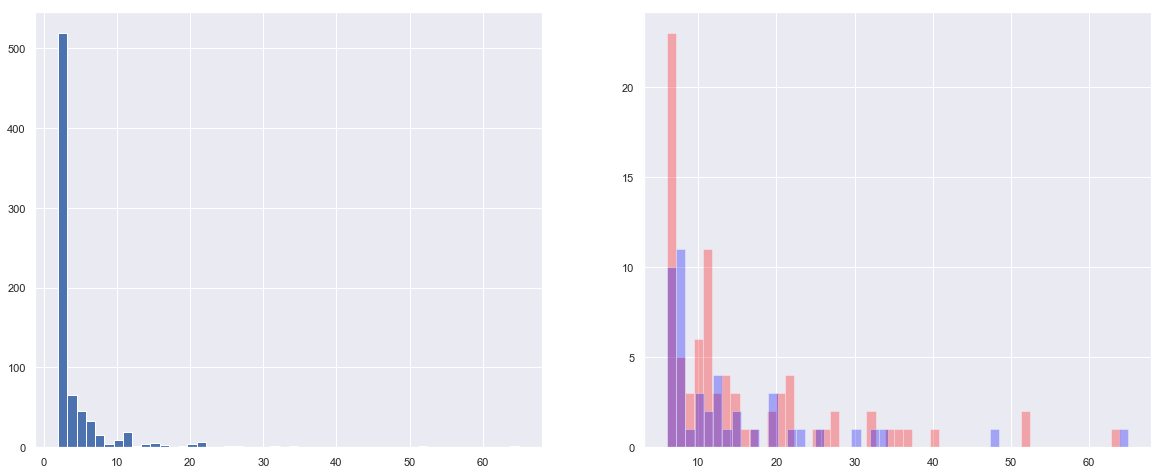

In [5]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))
ax0.hist(dd[dd.mut_key.number > 1].mut_key.number, bins=50);
# 0.1%
ax1.hist(dd[(dd.mut_key.number > 5) & (dd.VEP_gnomAD_total_AF_max.x >= 0.001)].mut_key.number, bins=50, alpha = 0.3, color='red');
ax1.hist(dd[(dd.mut_key.number > 5) & (dd.VEP_gnomAD_total_AF_max.x < 0.001)].mut_key.number, bins=50, alpha = 0.3, color='blue');

In [81]:
get_table(dd.mut_key.number).head()

,count_,freq_
1,3655,82.8%
2,401,9.1%
3,118,2.7%
4,66,1.5%
5,45,1.0%


In [191]:
dd.sort_values(('mut_key', 'number'), ascending=False).head(10)

mut_key VEP_SYMBOL VEP_gnomAD_total_AF_max        
                         number          x                       x     str
mut_key                                                                   
6_29910549_G_A               65      HLA-A                0.000359   0.04%
7_128829040_GCT_-            64        SMO                0.001050   0.11%
9_101867538_GGCGGCGGC_-      52     TGFBR1                0.096264   9.63%
3_49722761_C_A               52       MST1                0.066230   6.62%
X_66765161_A_T               48         AR                0.000591   0.06%
6_31324509_T_A               40      HLA-B                0.105439  10.54%
6_31324496_G_T               37      HLA-B                0.003171   0.32%
13_21562482_-_GGGGCG         35      LATS2                0.425597  42.56%
7_55242478_G_C               34       EGFR                0.000000   0.00%
5_236678_G_A                 34       SDHA                0.001161   0.12%

Text(0, 0.5, 'count')

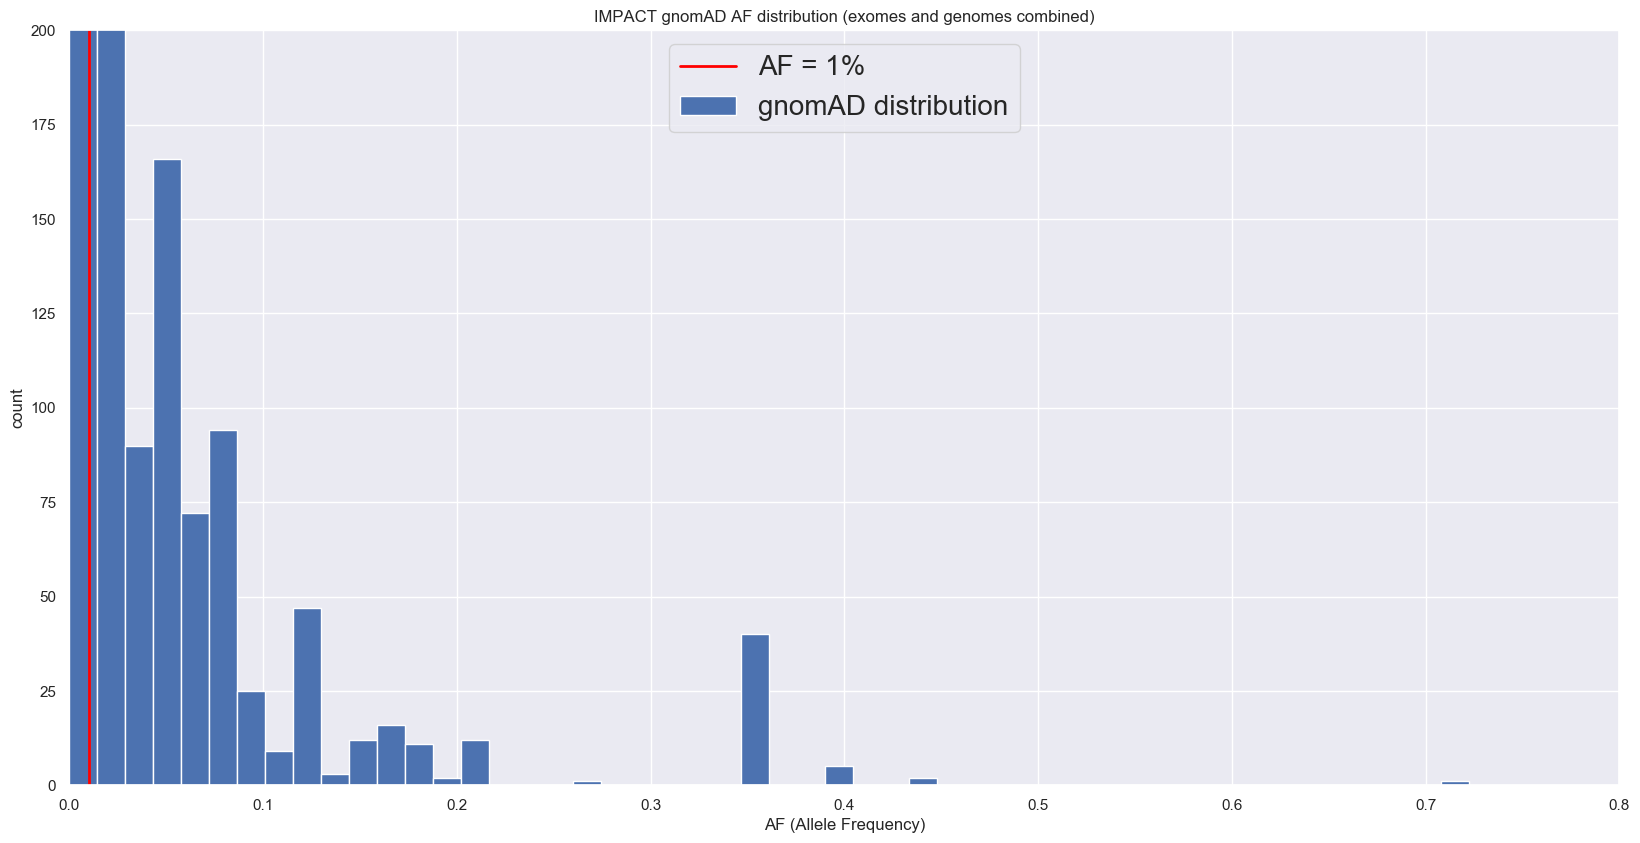

In [78]:
plt.figure(figsize=(20,10), dpi=100)
plt.hist(impact.VEP_gnomAD_total_AF, bins=50, label='gnomAD distribution')
plt.xlim(0.0, 0.8)
plt.ylim(0, 200)
plt.plot([0.01, 0.01], [0, 200], '-', color='red', linewidth=2, label='AF = 1%')
plt.legend(loc='upper center', prop={'size': 20})
plt.title("IMPACT gnomAD AF distribution (exomes and genomes combined)")
plt.xlabel("AF (Allele Frequency)")
plt.ylabel("count")

In [22]:
impact[impact.VEP_gnomAD_total_AF > 0.001].shape

(2799, 65)

In [23]:
get_table(impact[impact.VEP_gnomAD_total_AF > 0.01].is_artefact)

,count_,freq_
True,928,89.3%
False,111,10.7%


In [7]:
impact[impact.mut_key == '13_21562482_-_GGGGCG']

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,confidence_class,sample_coverage,mut_key,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_COSMIC_CNT,VEP_gnomAD_AF,sample_mut_key,patient_key,frequency_in_normals,VEP_SIFT_class,VEP_SIFT_score,VEP_PolyPhen_class,VEP_PolyPhen_score,VEP_in_dbSNP,VEP_gnomAD_total_AF_AFR,VEP_gnomAD_total_AF_AMR,VEP_gnomAD_total_AF_ASJ,VEP_gnomAD_total_AF_EAS,VEP_gnomAD_total_AF_FIN,VEP_gnomAD_total_AF_NFE,VEP_gnomAD_total_AF_OTH,VEP_gnomAD_total_AF_max,VEP_gnomAD_total_AF,Kaviar_AF,is_a_hotspot,is_a_3d_hotspot,oncogenic,gene_type,is_artefact,is_driver
506,LATS2,13,21562482,21562483,nonframeshift_insertion,INS,-,GGGGCG,P-0000102-T02-IM3,c.1431_1436dupCGCCCC,p.P479_A480dup,71,0.16901,12,49,0.02041,1,6,65,1,11,UNLIKELY,755,13_21562482_-_GGGGCG,Ins,LATS2,c.1436_1437insCGCCCC,p.A480_A481insPA,inframe_codon_gain,inframe_insertion,LATS2,c.1431_1436dup,p.P479_A480dup,P/PAP,insertion,4|8,NaN,MODERATE,unknown,4,0.1679,P-0000102-T02-IM3_13_21562482_-_GGGGCG,P-0000102,0.000,unknown,NaN,unknown,NaN,True,0.253049,0.235823,0.275298,0.233855,0.415554,0.425597,0.385258,0.425597,0.352111,0.000142,unknown,unknown,Predicted Oncogenic,tsg,True,True
3910,LATS2,13,21562482,21562483,nonframeshift_insertion,INS,-,GGGGCG,P-0000866-T01-IM3,c.1431_1436dupCGCCCC,p.P479_A480dup,59,0.18644,11,23,0.00000,0,5,54,0,11,UNLIKELY,779,13_21562482_-_GGGGCG,Ins,LATS2,c.1436_1437insCGCCCC,p.A480_A481insPA,inframe_codon_gain,inframe_insertion,LATS2,c.1431_1436dup,p.P479_A480dup,P/PAP,insertion,4|8,NaN,MODERATE,unknown,4,0.1679,P-0000866-T01-IM3_13_21562482_-_GGGGCG,P-0000866,0.000,unknown,NaN,unknown,NaN,True,0.253049,0.235823,0.275298,0.233855,0.415554,0.425597,0.385258,0.425597,0.352111,0.000142,unknown,unknown,Predicted Oncogenic,tsg,True,True
3940,LATS2,13,21562482,21562483,nonframeshift_insertion,INS,-,GGGGCG,P-0000877-T01-IM3,c.1431_1436dupCGCCCC,p.P479_A480dup,80,0.12500,10,35,0.00000,0,9,71,0,10,UNLIKELY,538,13_21562482_-_GGGGCG,Ins,LATS2,c.1436_1437insCGCCCC,p.A480_A481insPA,inframe_codon_gain,inframe_insertion,LATS2,c.1431_1436dup,p.P479_A480dup,P/PAP,insertion,4|8,NaN,MODERATE,unknown,4,0.1679,P-0000877-T01-IM3_13_21562482_-_GGGGCG,P-0000877,0.000,unknown,NaN,unknown,NaN,True,0.253049,0.235823,0.275298,0.233855,0.415554,0.425597,0.385258,0.425597,0.352111,0.000142,unknown,unknown,Predicted Oncogenic,tsg,True,True
3949,LATS2,13,21562482,21562483,nonframeshift_insertion,INS,-,GGGGCG,P-0000820-T02-IM3,c.1431_1436dupCGCCCC,p.P479_A480dup,98,0.14286,14,37,0.00000,0,19,77,3,11,UNLIKELY,475,13_21562482_-_GGGGCG,Ins,LATS2,c.1436_1437insCGCCCC,p.A480_A481insPA,inframe_codon_gain,inframe_insertion,LATS2,c.1431_1436dup,p.P479_A480dup,P/PAP,insertion,4|8,NaN,MODERATE,unknown,4,0.1679,P-0000820-T02-IM3_13_21562482_-_GGGGCG,P-0000820,0.000,unknown,NaN,unknown,NaN,True,0.253049,0.235823,0.275298,0.233855,0.415554,0.425597,0.385258,0.425597,0.352111,0.000142,unknown,unknown,Predicted Oncogenic,tsg,True,True
3960,LATS2,13,21562482,21562483,nonframeshift_insertion,INS,-,GGGGCG,P-0000880-T01-IM3,c.1431_1436dupCGCCCC,p.P479_A480dup,78,0.12821,10,42,0.00000,0,7,71,0,10,UNLIKELY,567,13_21562482_-_GGGGCG,Ins,LATS2,c.1436_1437insCGCCCC,p.A480_A481insPA,inframe_codon_gain,inframe_insertion,LATS2,c.1431_1436dup,p.P479_A480dup,P/PAP,insertion,4|8,NaN,MODERATE,unknown,4,0.1679,P-0000880-T01-IM3_13_21562482_-_GGGGCG,P-0000880,0.000,unknown,NaN,unknown,NaN,True,0.253049,0.235823,0.275298,0.233855,0.415554,0.425597,0.385258,0.425597,0.352111,0.000142,unknown,unknown,Predicted Oncogenic,tsg,True,True
4721,LATS2,13,21562482,21562483,nonframeshift_insertion,INS,-,GGGGCG,P-0000377-T02-IM3,c.1431_1436dup

## Hotspot real

In [239]:
aggregation = {
    'mut_key': {'number': 'count', 'more_than_one': lambda x: x.count() > 1},
    'VEP_SYMBOL': {'x': lambda x: x.iloc[0]}
}

dd = impact[~impact.is_artefact].groupby('mut_key').aggregate(aggregation)
dd.head(10)

/Users/guilminp/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


mut_key               VEP_SYMBOL
                                  number more_than_one          x
mut_key                                                          
10_104263912_G_A                       1         False       SUFU
10_104263932_GCGCCCCCGGCCCCACC_-       2          True       SUFU
10_104263935_C_-                       1         False       SUFU
10_104263935_C_T                       1         False       SUFU
10_104263941_G_A                       3          True       SUFU
10_104263952_C_-                       1         False       SUFU
10_104263973_-_C                      12          True       SUFU
10_104263974_C_-                       2          True       SUFU
10_104263979_C_A                       1         False       SUFU
10_104263992_C_T                       1         False       SUFU

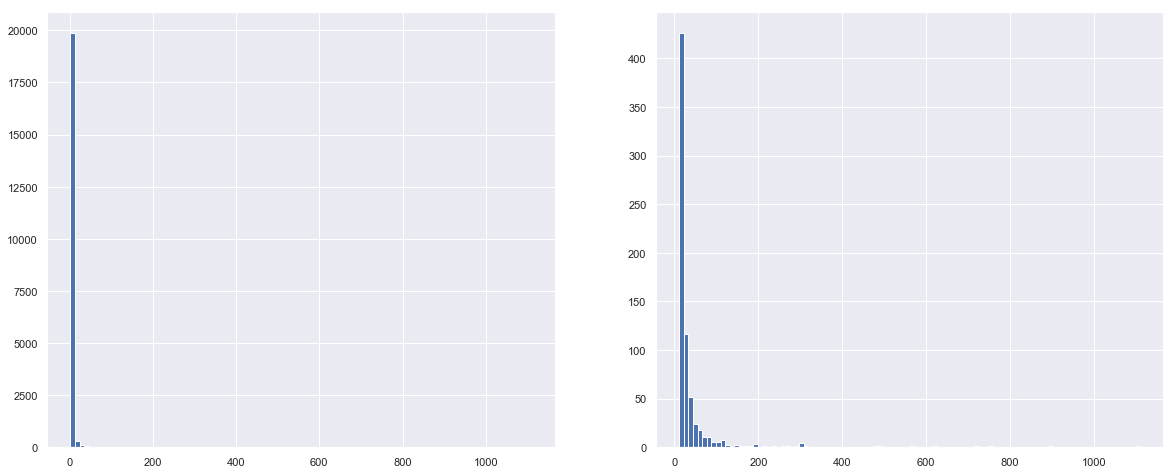

In [199]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,8))
ax0.hist(dd[dd.mut_key.number > 1].mut_key.number, bins=100);
ax1.hist(dd[dd.mut_key.number > 10].mut_key.number, bins=100);

## Impact without hotspots

In [106]:
def get_random_sample(x):
    if x.shape[0] > 3:
        return x.sample(3, random_state=42).tolist()
    else:
        return x.tolist()

aggregation = {
    'mut_key': {'number': 'count',
                'more_than_three': lambda x: x.count() > 3},
    
    'sample_mut_key': {'list': lambda x: x.tolist(),
                       'selected': lambda x: get_random_sample(x)}
}

dd = impact[10000:20000].groupby('mut_key').aggregate(aggregation)
dd[dd.mut_key.number>2].tail(10)

/Users/guilminp/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


mut_key                  \
                 number more_than_three   
mut_key                                   
9_21971017_G_A        3           False   
9_21971111_G_A        3           False   
9_21971120_G_A        8            True   
9_21971186_G_A        4            True   
9_5123048_C_T         3           False   
9_5462876_C_G         3           False   
9_80409488_T_A        4            True   
9_80409488_T_G        4            True   
X_123179197_C_T       3           False   
X_66765161_A_T        3           False   

                                                                                                                                                                                                                                                                                   sample_mut_key  \
                                                                                                                                                                                                                                                                                             list   
mut_key                                                                                                                                                                                                                                                                                             
9_21971017_G_A                                                                                                                                                                             [P-0003007-T01-IM3_9_21971017_G_A, P-0003182-T01-IM5_9_21971017_G_A, P-0003872-T01-IM5_9_21971017_G_A]   
9_21971111_G_A                                                                                                                                                                             [P-0002044-T01-IM3_9_21971111_G_A, P-0002519-T01-IM3_9_21971111_G_A, P-0003301-T01-IM5_9_21971111_G_A]   
9_21971120_G_A   [P-0002054-T01-IM3_9_21971120_G_A, P-0002117-T01-IM3_9_21971120_G_A, P-0002305-T01-IM3_9_21971120_G_A, P-0002367-T01-IM3_9_21971120_G_A, P-0002458-T01-IM3_9_21971120_G_A, P-0002717-T01-IM3_9_21971120_G_A, P-0003610-T01-IM5_9_21971120_G_A, P-0003871-T01-IM5_9_21971120_G_A]   
9_21971186_G_A                                                                                                                                           [P-0002222-T01-IM3_9_21971186_G_A, P-0002664-T01-IM3_9_21971186_G_A, P-0002765-T01-IM3_9_21971186_G_A, P-0003524-T01-IM5_9_21971186_G_A]   
9_5123048_C_T                                                                                                                                                                                 [P-0002097-T01-IM3_9_5123048_C_T, P-0003116-T01-IM5_9_5123048_C_T, P-0003116-T02-IM5_9_5123048_C_T]   
9_5462876_C_G                                                                                                                                                                                 [P-0001984-T01-IM3_9_5462876_C_G, P-0002012-T01-IM3_9_5462876_C_G, P-0003520-T01-IM5_9_5462876_C_G]   
9_80409488_T_A                                                                                                                                           [P-0002418-T01-IM3_9_80409488_T_A, P-0002429-T01-IM3_9_80409488_T_A, P-0003199-T01-IM5_9_80409488_T_A, P-0003359-T01-IM5_9_80409488_T_A]   
9_80409488_T_G                                                                                                                                           [P-0002517-T01-IM3_9_80409488_T_G, P-0002798-T01-IM3_9_80409488_T_G, P-0003197-T01-IM5_9_80409488_T_G, P-0003881-T01-IM5_9_80409488_T_G]   
X_123179197_C_T                                                                                                                                                                         [P-0003438-T01-IM5_X_123179197_C_T, P-0003794-T01

In [304]:
impact_unified = impact[impact.sample_mut_key.isin(dd.sample_mut_key.selected)].copy()
print(impact_unified.shape)
get_table(impact_unified.is_artefact)

(132275, 67)


,count_,freq_
False,128345,97.0%
True,3930,3.0%


## Test

In [305]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)

from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=42, loss='deviance', max_depth=6, n_estimators=500)

In [306]:
def get_X_and_y(impact, features, categorical_features):
    data = impact.copy()
    data = data[features + ['is_artefact']]
    
    # transform categorical features
    numerical_features = [f for f in features if not f in categorical_features]
    data = pd.get_dummies(data, columns=categorical_features, sparse=True)

    # get reduced dataset
    positive_class_number = data[data.is_artefact].shape[0]
    data = pd.concat([data[data.is_artefact],
                        data[~data.is_artefact].iloc[:positive_class_number]], ignore_index=True)

    # shuffle data
    rng = np.random.RandomState(42)
    permutation = rng.permutation(len(data))
    data = data.iloc[permutation]
    data.reset_index(drop=True, inplace=True)

    # get features matrix X (n_samples x n_features) and target array y (n_samples)
    X = data.drop('is_artefact', axis=1)
    X = X.astype(float)
    y = data['is_artefact']

    get_table(y)
    
    return X, y

In [307]:
impact_unified['is_SNV'] = (impact_unified.VEP_VARIANT_CLASS == 'SNV')

features = ['t_depth',
 't_vaf',
 't_alt_count',
 'n_depth',
 'sample_coverage',
 'is_SNV',
 'VEP_COSMIC_CNT',
 'frequency_in_normals',
 'VEP_gnomAD_total_AF_max',
 'VEP_gnomAD_total_AF',
 'Chromosome']

categorical_features = ['Chromosome']

In [308]:
X, y = get_X_and_y(impact_unified, features, categorical_features)
metrics = run_model(model, X, y, cv_strategy, n_jobs=5)
print_mean_metrics(metrics)

Run model... done! (15.70s)
▴ Mean accuracy    : 0.850 ± 0.029
▴ Mean ROC AUC     : 0.922 ± 0.013
▴ Mean F1-score    : 0.847 ± 0.032
▴ Average precision: 0.932 ± 0.012


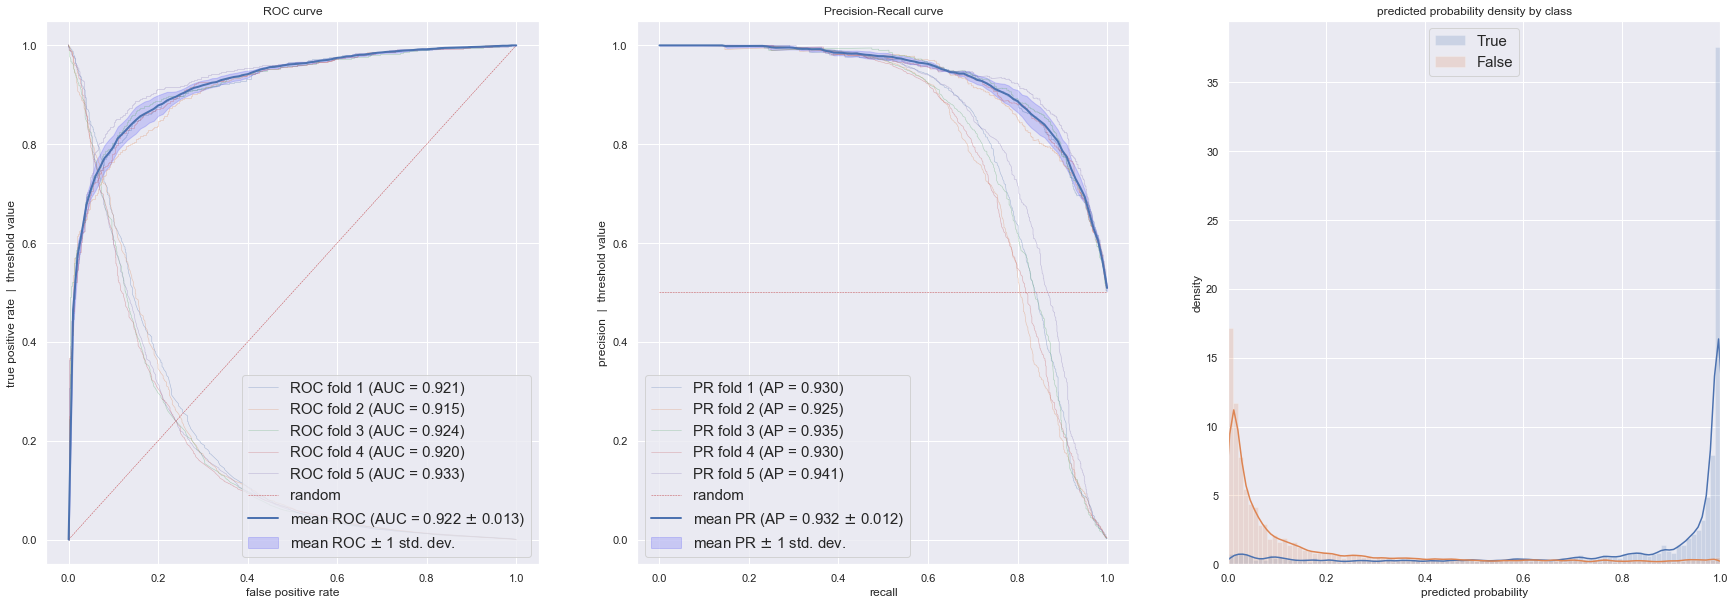

In [309]:
plot_threshold_decision_metrics(metrics)

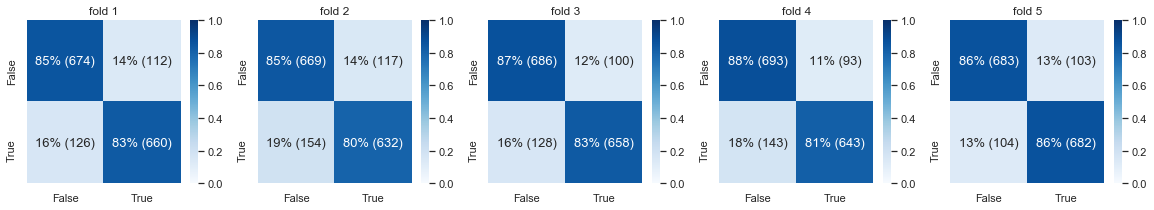

In [310]:
plot_confusion_matrix(metrics)

## Get inconsistent artefacts

**Classified as driver**

In [291]:
get_table(impact[impact.is_artefact].is_driver)

,count_,freq_
False,5909,82.1%
True,1290,17.9%


**Classified as somatic at least once**

In [292]:
somatic_mut_keys = impact[~impact.is_artefact].mut_key.values
impact['as_somatic'] = impact.mut_key.isin(somatic_mut_keys)
get_table(impact[impact.is_artefact].as_somatic)

,count_,freq_
False,4845,67.3%
True,2354,32.7%


**Both**

In [293]:
impact['is_inconsistent'] = impact.as_somatic | impact.is_driver
get_table(impact[impact.is_artefact].is_inconsistent)

,count_,freq_
False,4115,57.2%
True,3084,42.8%


**At the key level**

In [296]:
get_table(impact_unified[impact_unified.is_artefact].is_inconsistent)

,count_,freq_
False,2918,74.2%
True,1012,25.8%
